<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 2

</h4>

# Personal Data

In [1]:
# Set your student number
student_number = 400101656
Name = 'Pantea'
Last_Name = 'Amoie'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch.

## Question 1) Convolutional Neural Networks ``(50 pt.)``

In this question, you'll be coding up a convolutional neural network from scratch to classify images using PyTorch.  

### Instructions
- Install PyTorch following the instructions [here](https://pytorch.org/).
- Install the [`torchinfo` package](https://github.com/TylerYep/torchinfo) to visualize the network architecture and the number of parameters. The maximum number of parameters you are allowed to use for your network is **100,000**.
- You are required to complete the functions defined in the code blocks following each question. Fill out sections of the code marked `"YOUR CODE HERE"`.
- You're free to add any number of methods within each class.
- You may also add any number of additional code blocks that you deem necessary.

### Data Preparation
In this assignment, we will use the Fashion-MNIST dataset. Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  

#### Data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.  

#### Labels

Each training and test example is assigned to one of the following labels:

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Fashion-MNIST is included in the `torchvision` library.

In [2]:
# Import required packages
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Transform to normalize the data and convert to a tensor
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

# Download the data
dataset = FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)

### Data Exploration
Let's take a look at the classes in our dataset.

In [4]:
print(dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Now, visualize an instance from each class.

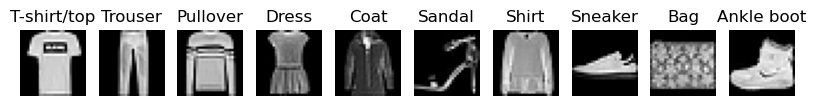

In [5]:
num_classes = len(dataset.classes)
classes = dataset.classes
fig, axs = plt.subplots(1, num_classes, figsize=(10, 10))
class_images = [None] * num_classes

for image, label in dataset:
    if class_images[label] is None:
        class_images[label] = image
    # stop the iteration if we have found an image for each class
    if all(img is not None for img in class_images):
        break

for i in range(num_classes):
    axs[i].imshow(class_images[i].squeeze(), cmap='gray')
    axs[i].set_title(classes[i])
    axs[i].axis('off')

plt.show()

### Creating Training and Validation Datasets

The `split_indices` function takes in the size of the entire dataset, `n`, the fraction of data to be used as validation set, `val_frac`, and the random seed and returns the indices of the data points to be added to the validation dataset.

In [6]:
def split_indices(n, val_frac, seed):
    # Determine the size of the validation set
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # Create random permutation between 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [7]:
val_frac =  0.2
rand_seed =  42

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)
print("number of samples in training set: {}".format(len(train_indices)))
print("number of samples in validation set: {}".format(len(val_indices)))

number of samples in training set: 48000
number of samples in validation set: 12000


Next, we make use of the built-in dataloaders in PyTorch to create iterables of our our training and validation sets. This helps in avoiding fitting the whole dataset into memory and only loads a batch of the data that we can decide.

In [8]:
# Import required packages
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [9]:
batch_size = 64

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size,
                     sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size,
                   sampler=val_sampler)

Plot images in a sample batch of data.

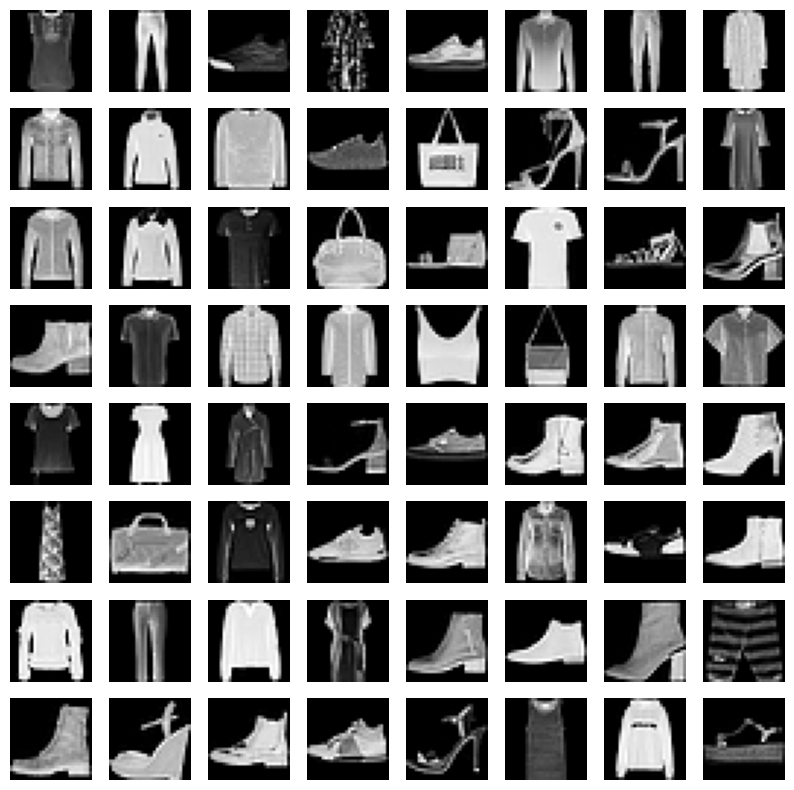

In [10]:
# getting a sample batch from the training data loader
sample_batch = next(iter(train_dl))
# extracting images from a sample batch
images, labels = sample_batch

# creating a grid of images using subplots
num_images = len(images)
num_rows = int(np.sqrt(num_images))
num_cols = int(np.ceil(num_images / num_rows))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, axis in enumerate(axes.flat):
    # if the current index i is less than the total number of images num_images
    if i < num_images:
        # permuting to rearrange the dimensions of a tensor so that it
        # will fit matplotlib's format which is [height, width, channels]
        axis.imshow(images[i].permute(1, 2, 0), cmap='gray')
        axis.axis('off')
    else:
        axis.axis('off')

plt.show()

### Building the Model
Create your model by defining the network architecture in the `ImageClassifierNet` class.<br>
**NOTE:** The number of parameters in your network must be $\leq$ 100,000.

In [11]:
!pip install torchinfo

In [12]:
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.optim import Adam
import torch
import torch.optim as optim

In [13]:
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

class ImageClassifierNet(nn.Module):
    def __init__(self, n_channels=1):
        super(ImageClassifierNet, self).__init__()
        # input: 3(channels) * 28 * 28
        # output: 16(channels) * 28 * 28
        # kernel: 3 * 3
        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=16, kernel_size=3, stride=1, padding=1)
        # input: 16(channels) * 28 * 28
        # output: 32(channels) * 28 * 28
        # kernel: 3 * 3
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # input: 32(channels) * 28 * 28
        # output: 64(channels) * 28 * 28
        # kernel: 3 * 3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # fully connected layer
        self.fc1 = nn.Linear(64 * 3 * 3, 128) 
        self.fc2 = nn.Linear(128, 10)  # 10 output classes
        
    def forward(self, X):
        # Conv1 + ReLU + Max Pooling
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        # Conv2 + ReLU + Pooling
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        # Conv3 + ReLU + Pooling
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        # flattening
        X = X.view(-1, 64 * 3 * 3)  
        # fully connected layer + ReLU
        X = F.relu(self.fc1(X))
         # output layer
        X = self.fc2(X)
        return X



In [14]:
model = ImageClassifierNet(n_channels=1)

The following code block prints your network architecture. It also shows the total number of parameters in your network (see `Total params`).  

**NOTE: The total number of parameters in your model should be <= 100,000.**

In [15]:
summary(model, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [64, 10]                  --
├─Conv2d: 1-1                            [64, 16, 28, 28]          160
├─Conv2d: 1-2                            [64, 32, 14, 14]          4,640
├─Conv2d: 1-3                            [64, 64, 7, 7]            18,496
├─Linear: 1-4                            [64, 128]                 73,856
├─Linear: 1-5                            [64, 10]                  1,290
Total params: 98,442
Trainable params: 98,442
Non-trainable params: 0
Total mult-adds (M): 129.05
Input size (MB): 0.20
Forward/backward pass size (MB): 11.31
Params size (MB): 0.39
Estimated Total Size (MB): 11.90

### Train the model
Complete the `train_model` function to train your model on a dataset. Tune your network architecture and hyperparameters on the validation set.

In [16]:
def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.
    
    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader (can be an empty list if no validation set)
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate
    
    Returns:
        The trained model.
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    
    # Record these values at the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    # Initialize the optimizer
    optimizer = opt_fn(model.parameters(), lr=lr)
    
    for epoch in range(n_epochs):
        # Set the model to training mode
        model.train()  
        total_loss, correct, total = 0, 0, 0  # Initialize metrics

        # Iterate over the training data
        for images, labels in train_dl:
            # Move data to GPU
            images, labels = images.cuda(), labels.cuda()
            # Zero the gradients
            optimizer.zero_grad() 
            # Forward pass
            outputs = model(images)  
            # Compute the loss
            loss = loss_fn(outputs, labels)  
            # Backward pass
            loss.backward() 
            # Update the parameters
            optimizer.step()  
            # Accumulate the loss
            total_loss += loss.item() * images.size(0)  
            # Get the predicted classes
            _, predicted = torch.max(outputs.data, 1)  
            # Accumulate the total number of samples
            total += labels.size(0)  
            # Accumulate the number of correct predictions
            correct += (predicted == labels).sum().item()  
            
        # Record the average training loss
        train_losses.append(total_loss / total)  
        # Record the training accuracy
        train_accuracies.append(correct / total)  

        # Validation step (only if val_dl is provided and not empty)
        if val_dl:
            model.eval()  # Set the model to evaluation mode
            total_loss, correct, total = 0, 0, 0  # Initialize metrics
            with torch.no_grad():  # Disable gradient computation
                for images, labels in val_dl:
                    images, labels = images.cuda(), labels.cuda()  # Move data to GPU
                    # Forward pass
                    outputs = model(images)  
                    # Compute the loss
                    loss = loss_fn(outputs, labels)  
                    # Accumulate the loss
                    total_loss += loss.item() * images.size(0)
                    # Get the predicted classes
                    _, predicted = torch.max(outputs.data, 1)  
                    # Accumulate the total number of samples
                    total += labels.size(0)  
                    # Accumulate the number of correct predictions
                    correct += (predicted == labels).sum().item()  
                    
            # Record the average validation loss
            val_losses.append(total_loss / total)
            # Record the validation accuracy
            val_accuracies.append(correct / total) 
            
            print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")
        else:
            print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}")

    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [17]:
num_epochs = 10 # Number of training epochs
loss_fn = nn.CrossEntropyLoss() # Define the loss function
opt_fn = optim.Adam # Select an optimizer
lr = 0.001  # Set the learning rate

In [18]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)

C:\Users\LEGION\anaconda3\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/10, Train Loss: 0.5729, Train Acc: 0.7908, Val Loss: 0.4025, Val Acc: 0.8531
Epoch 2/10, Train Loss: 0.3466, Train Acc: 0.8742, Val Loss: 0.3232, Val Acc: 0.8819
Epoch 3/10, Train Loss: 0.2924, Train Acc: 0.8925, Val Loss: 0.2895, Val Acc: 0.8928
Epoch 4/10, Train Loss: 0.2616, Train Acc: 0.9045, Val Loss: 0.2769, Val Acc: 0.8989
Epoch 5/10, Train Loss: 0.2389, Train Acc: 0.9115, Val Loss: 0.2541, Val Acc: 0.9089
Epoch 6/10, Train Loss: 0.2187, Train Acc: 0.9186, Val Loss: 0.2502, Val Acc: 0.9087
Epoch 7/10, Train Loss: 0.2017, Train Acc: 0.9237, Val Loss: 0.2616, Val Acc: 0.9062
Epoch 8/10, Train Loss: 0.1867, Train Acc: 0.9306, Val Loss: 0.2564, Val Acc: 0.9058
Epoch 9/10, Train Loss: 0.1752, Train Acc: 0.9329, Val Loss: 0.2634, Val Acc: 0.9083
Epoch 10/10, Train Loss: 0.1605, Train Acc: 0.9392, Val Loss: 0.2394, Val Acc: 0.9177


### Plot loss and accuracy

In [19]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")

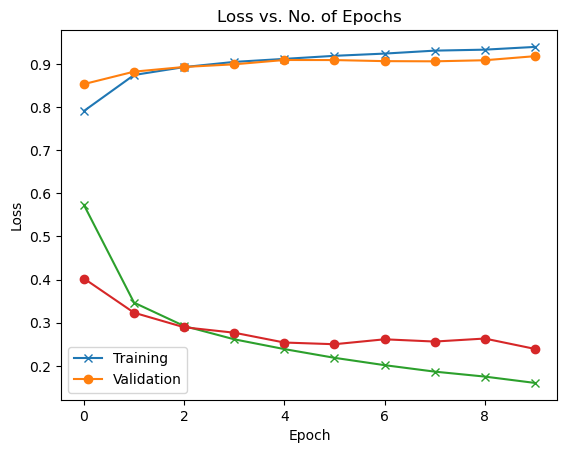

In [20]:
plot_accuracy(train_accuracies, val_accuracies)
plot_losses(train_losses, val_losses)

### Train a model on the entire dataset

In [21]:
indices, _ = split_indices(len(dataset), 0, rand_seed)

sampler = SubsetRandomSampler(indices)
dl = DataLoader(dataset, batch_size, sampler=sampler)

In [22]:
num_epochs = 20 # Max number of training epochs
lr = 0.001 # Set the learning rate

In [23]:
model, _, _, _, _ = train_model(num_epochs, model, dl, [], loss_fn, opt_fn, lr)

Epoch 1/20, Train Loss: 0.1747, Train Acc: 0.9351
Epoch 2/20, Train Loss: 0.1568, Train Acc: 0.9422
Epoch 3/20, Train Loss: 0.1453, Train Acc: 0.9446
Epoch 4/20, Train Loss: 0.1343, Train Acc: 0.9486
Epoch 5/20, Train Loss: 0.1236, Train Acc: 0.9522
Epoch 6/20, Train Loss: 0.1137, Train Acc: 0.9571
Epoch 7/20, Train Loss: 0.1030, Train Acc: 0.9601
Epoch 8/20, Train Loss: 0.0972, Train Acc: 0.9632
Epoch 9/20, Train Loss: 0.0896, Train Acc: 0.9653
Epoch 10/20, Train Loss: 0.0820, Train Acc: 0.9681
Epoch 11/20, Train Loss: 0.0747, Train Acc: 0.9713
Epoch 12/20, Train Loss: 0.0696, Train Acc: 0.9732
Epoch 13/20, Train Loss: 0.0646, Train Acc: 0.9754
Epoch 14/20, Train Loss: 0.0593, Train Acc: 0.9778
Epoch 15/20, Train Loss: 0.0557, Train Acc: 0.9790
Epoch 16/20, Train Loss: 0.0542, Train Acc: 0.9792
Epoch 17/20, Train Loss: 0.0470, Train Acc: 0.9822
Epoch 18/20, Train Loss: 0.0481, Train Acc: 0.9821
Epoch 19/20, Train Loss: 0.0458, Train Acc: 0.9829
Epoch 20/20, Train Loss: 0.0397, Train A

### Check Predictions
Now, you should evaluate your model on dataset. Specifically, you should calculate the class probabilities for each image, and then visualize these probabilities along with the image itself. Please include a function `view_prediction` in your code that takes an image, its label, the calculated probabilities, and the list of class names as input, and plots the image along with the probabilities.

In [25]:
def view_prediction(image, label, probabilities, class_names):
    # Visualize the image, its true label, and the predicted probabilities.
    
    # Unnormalize the image for display
    image = image / 2 + 0.5  # unnormalize
    image = image.cpu().numpy()
    
    # Plot the image
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image.transpose((1, 2, 0)), cmap='gray')
    plt.title(f'True Label: {class_names[label]}')
    plt.axis('off')
    
    # Plot the probabilities
    plt.subplot(1, 2, 2)
    plt.barh(range(len(class_names)), probabilities.cpu().numpy())
    plt.yticks(range(len(class_names)), class_names)
    plt.xlabel('Probability')
    plt.title('Predicted Probabilities')
    plt.show()
    

### Save the model

In [26]:
torch.save(model, 'model')

### Calculate accuracy on the test set

In [27]:
test_dataset = FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
test_dl = DataLoader(test_dataset, batch_size)

In [28]:
def evaluate(model, test_dl):
    """
    Evaluates your model on the test data.

    Args:
        model: ImageClassifierNet object
        test_dl: test dataloader

    Returns:
        Test accuracy.
    """
    model.eval()  # Set the model to evaluation mode
    correct, total = 0, 0
    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_dl:
            images, labels = images.cuda(), labels.cuda()  # Move data to GPU
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted classes
            total += labels.size(0)  # Accumulate the total number of samples
            correct += (predicted == labels).sum().item()  # Accumulate the number of correct predictions

    return correct / total  # Compute the accuracy

Test Accuracy = 0.9097


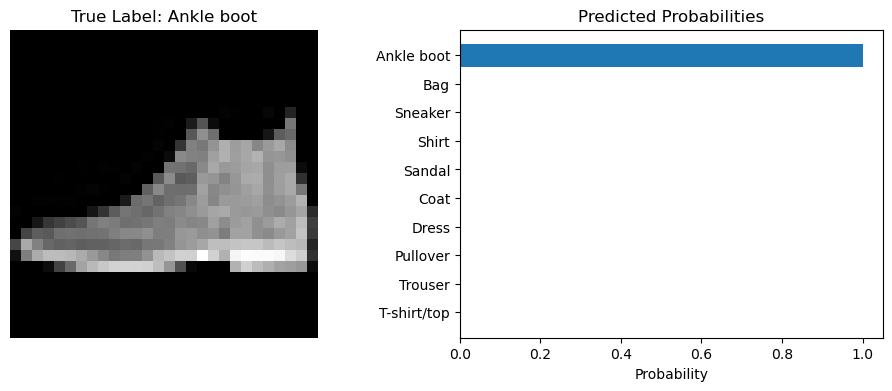

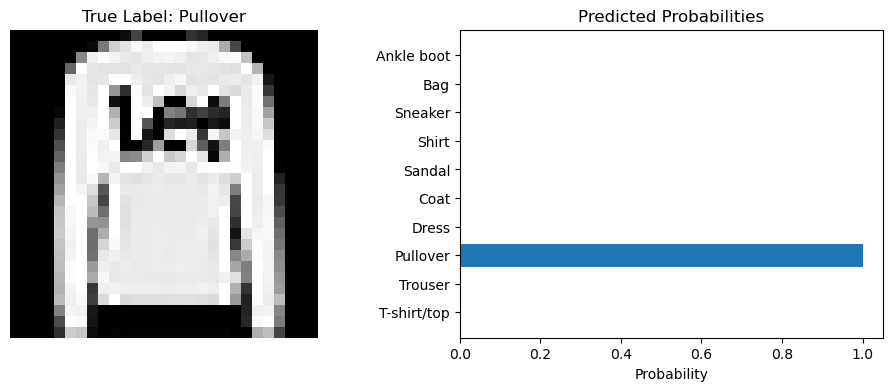

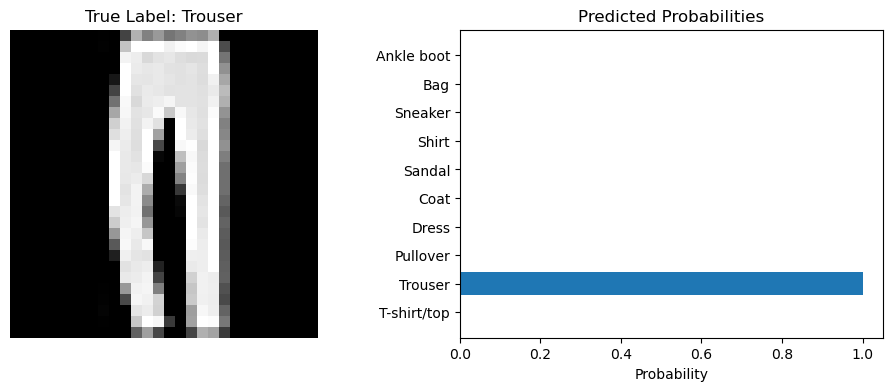

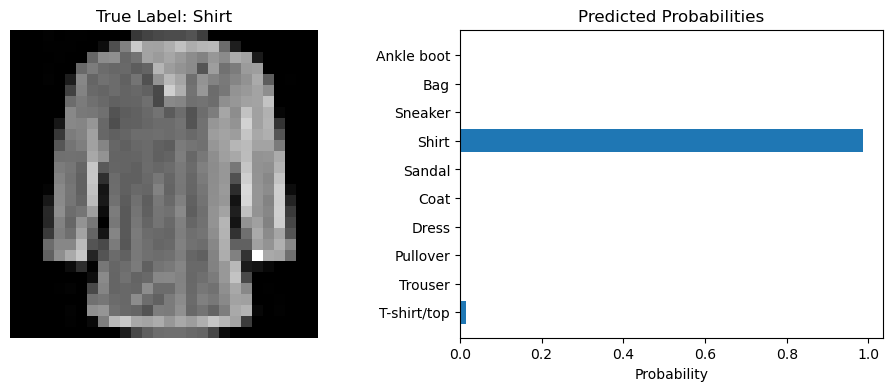

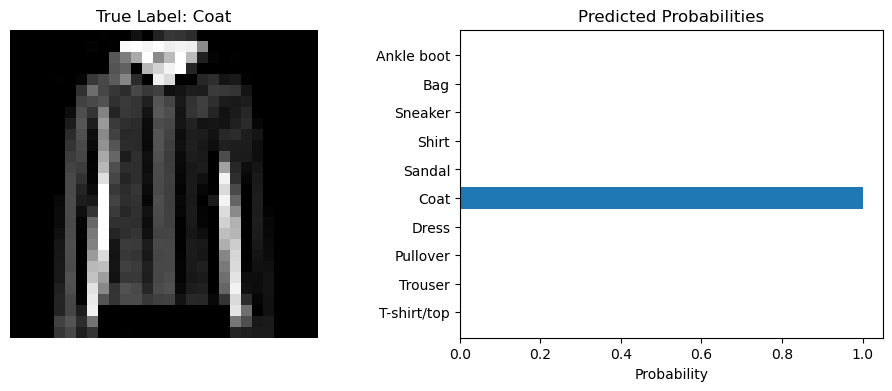

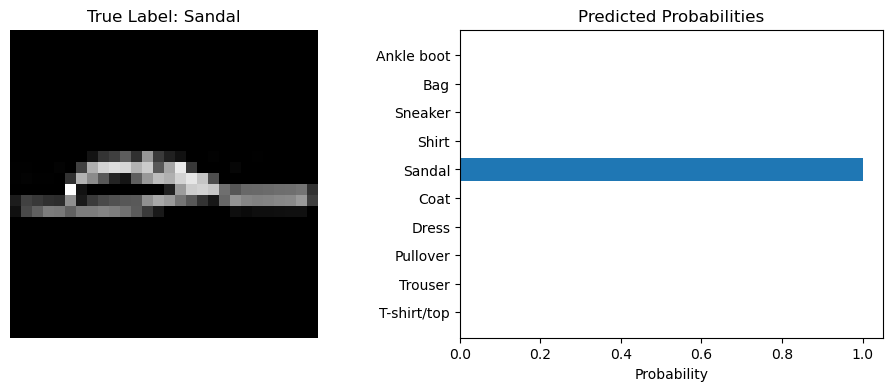

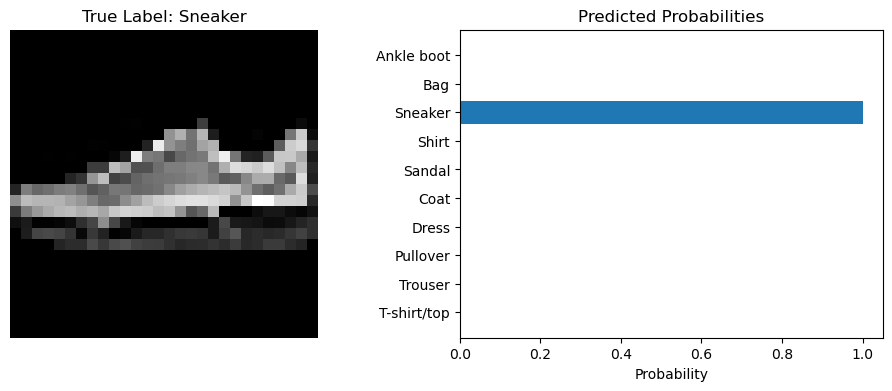

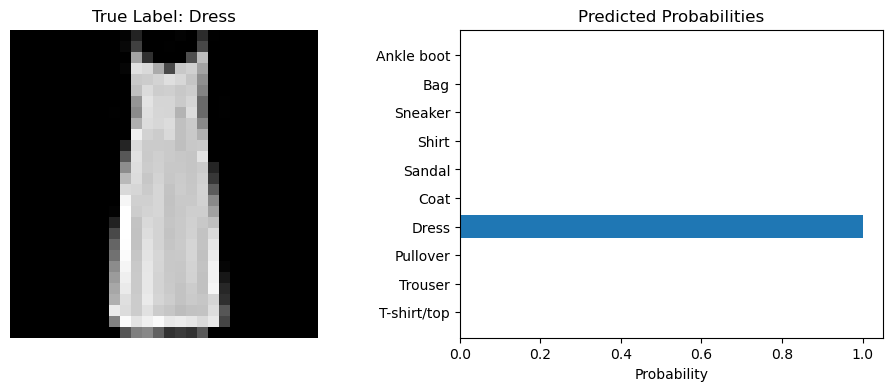

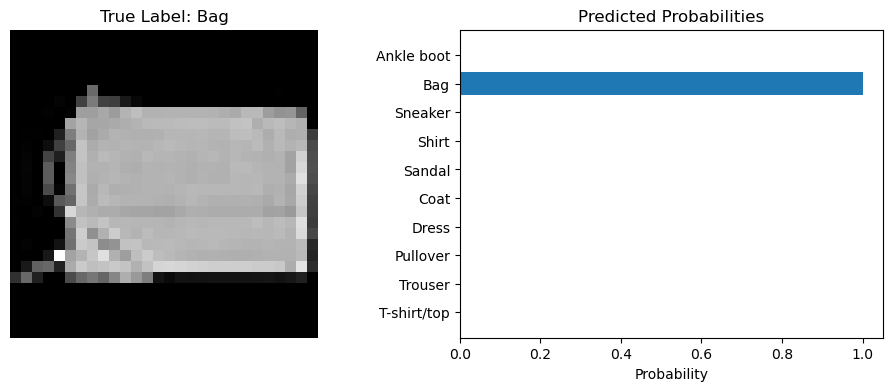

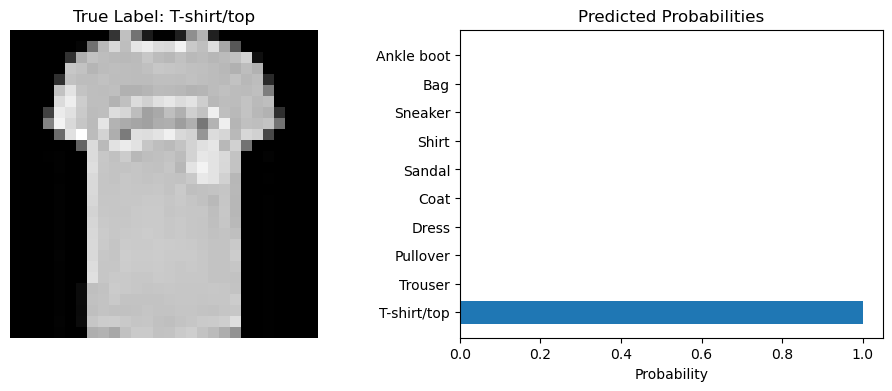

In [29]:
print("Test Accuracy = {:.4f}".format(evaluate(model, test_dl)))

class_names = test_dataset.classes  # List of class names
class_seen = set()  # To keep track of seen classes

# Get one batch of test data
for images, labels in test_dl:
    model.eval()
    with torch.no_grad():
        outputs = model(images.cuda())
        probabilities = F.softmax(outputs, dim=1)

    for i in range(len(labels)):
        label = labels[i].item()
        if label not in class_seen:
            class_seen.add(label)
            view_prediction(images[i], labels[i], probabilities[i], class_names)
        if len(class_seen) == len(class_names):
            break
    if len(class_seen) == len(class_names):
        break